## StackOverFlow Tags Prediction

**Aim :** Predict the tags (a.k.a. keywords, topics, summaries), given only the question text and its title
**About Data :**
- Train data 
        size = nearly 6.2GB
        Columns= ID,Title,Body,Tags
        Duplicates= Yes
        Null values = No
        Num_rows= Nearly 6.1 Million Rows with Duplicates
        
        Body contains HTML Tags, Code sniffets, urls etc..
        Title Contains html Tags..
        
- Test Data
       contains the same columns but without the Tags, which you are to predict.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-recruiting-iii-keyword-extraction/SampleSubmission.csv
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip
/kaggle/input/facebook-recruiting-iii-keyword-extraction/Test.zip


### Importing the Libraries 

In [112]:
# importing the Necssary modules
import matplotlib.pyplot as plt
import seaborn as sbn
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn import metrics
import warnings
import prettytable
from wordcloud import WordCloud
from sklearn.preprocessing import Normalizer

warnings.filterwarnings('ignore')
stemer=SnowballStemmer('english')

### Loding train_dataset of First 1 Million Rows (due to Memory constraint)

In [3]:
%%time
train_data=pd.read_csv("/kaggle/input/facebook-recruiting-iii-keyword-extraction/Train.zip",nrows=1000000)

CPU times: user 20.3 s, sys: 1.52 s, total: 21.8 s
Wall time: 21.9 s


In [19]:
# Initial Description about the data 
print("The Number of Question have in the dataset :",train_data.shape[0])
print("The Number of Columns have in the Dataset  :",train_data.shape[1])
print(train_data.columns)

The Number of Question have in the dataset : 1000000
The Number of Columns have in the Dataset  : 4
Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')


## Data PreProcessing 

### Checking and Removing the Duplicates from the Dataset

In [20]:
# droping the Id Column from the Dataset
train_data.drop(columns=["Id"],axis=1,inplace=True)

In [21]:
%%time
# number of duplicate values in the dataset is :
print("The Number of Duplicate values in the Dataset are :",train_data.duplicated().sum())
# Droping the Duplicates in the dataset
train_data.drop_duplicates(inplace=True)
print("The Number of Remains after Droping the Duplicated values from the Dataset :",train_data.shape)

The Number of Duplicate values in the Dataset are : 56418
The Number of Remains after Droping the Duplicated values from the Dataset : (943582, 3)
CPU times: user 10.7 s, sys: 103 ms, total: 10.8 s
Wall time: 10.8 s


### Checking Null and Removing the rows which contains Null Values in a dataset

In [22]:
# Checking the Missing Values in the Dataset
print(train_data.isnull().sum())
# Here only contains single Null values so it better to remove that row instead repacing the null values.
train_data.dropna(inplace=True)
# The Shape of the Dataset after Removing the rows which Contains Null vales
train_data.shape

Title    0
Body     0
Tags     1
dtype: int64


(943581, 3)

## Exploratory Data Analysis

**Instance Of a Dataset(Let display  a single Row)**

In [27]:
print("-"*50+"TITLE"+"-"*50)
print(train_data["Title"][30])
print("-"*50+"BODY"+"-"*50)
print(train_data["Body"][30])
print("-"*50+"TAGS"+"-"*50)
print(train_data["Tags"][30])

--------------------------------------------------TITLE--------------------------------------------------
MVC4 StyleBundle not resolving images
--------------------------------------------------BODY--------------------------------------------------
<p>My question is similar to this:</p>

<blockquote>
  <p><a href="http://stackoverflow.com/questions/9780099/asp-net-mvc-4-minification-background-images">ASP.NET MVC 4 Minification &amp; Background Images</a></p>
</blockquote>

<p>Except that I want to stick with MVC's own bundling if I can. I'm having a brain crash trying to figure out what the correct pattern is for specifying style bundles such that standalone css and image sets such as jQuery UI work.</p>

<p>I have a typical MVC site structure with <code>/Content/css/</code> which contains my base CSS such as <code>styles.css</code>. Within that css folder I also have subfolders such as <code>/jquery-ui</code> which contains its CSS file plus an <code>/images</code> folder. Image path

- Title Doesn't Contains the html tags
- Body Contains html tags, code sniffet, description etc..
- Tags 

### Tags Analysis

In [28]:
#Counting the Tags for each Question or Row in the Dataset
train_data["Count_tags"]=train_data.Tags.apply(lambda x:len(str(x).split())) # counting for each Query


Text(0, 0.5, 'Number of Quries')

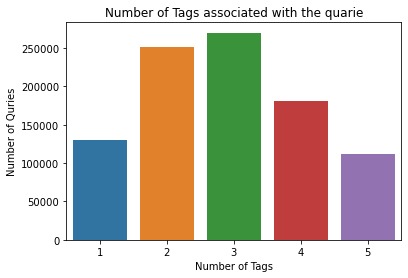

In [39]:
# Distibution of Tags 
sbn.countplot(train_data.Count_tags)
plt.title("Number of Tags associated with the quarie")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Quries")

**Maximum Tags in quary is :5**

**Most of the Questions contains 3 or 2 tags**

### Analyzing How Tags are Frequent in a Corpus
- Getting Most Frequent Tags in a Corpus.

In [40]:
# To get the frequent tags by the Countvectorizer
# GETTING THE Most Frequent Tags in the corpus.
tags_vector=CountVectorizer(tokenizer = lambda x: x.split(),binary=True)
x_tags=tags_vector.fit_transform(train_data.Tags)
count=x_tags.sum(axis=0)
freq_tags=pd.DataFrame()
freq_tags["tags"]=tags_vector.get_feature_names()
freq_tags["count"]=count.tolist()[0]
freq_tags.sort_values(by='count',ascending=False,inplace=True)
freq_tags.reset_index(inplace=True)
freq_tags.drop(columns="index",inplace=True)

In [43]:
print("----------------------The Top 10 Tags in the Corpus ---------------")
print(freq_tags["tags"][:10].values)
print("--------------------Top 10 Least Frequent tags in the Corpus--------------")
print(freq_tags.tail(10)["tags"].values)

----------------------The Top 10 Tags in the Corpus ---------------
['c#' 'java' 'php' 'javascript' 'android' 'jquery' 'c++' 'python' 'iphone'
 'asp.net']
--------------------Top 10 Least Frequent tags in the Corpus--------------
['error-console' 'math-table' 'telepathy' 'error-list'
 'error-messages-for' 'math-input-panel' 'restitution' 'materials'
 'errorformat' 'phpbms']


Text(0.5, 1.0, 'Occurence of Tags in corpus')

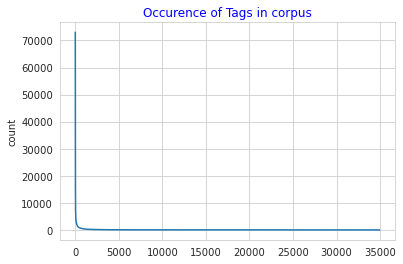

In [44]:
# frequency plotting of the Tags 
sbn.set_style("whitegrid")
sbn.lineplot(data=freq_tags,x=freq_tags.index,y="count")
plt.title("Occurence of Tags in corpus",color="blue")

- Large Number of Tags has occured rarely in the Corpus


### PLotting the Top 1000 Frequent Tags

Text(0.5, 1.0, 'Occurence of Tags in corpus')

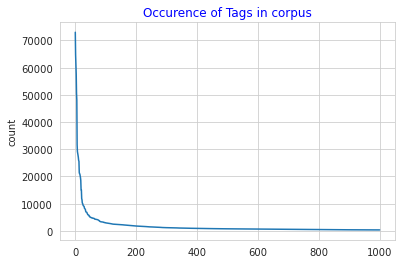

In [45]:
sbn.set_style("whitegrid")
sbn.lineplot(data=freq_tags.iloc[:1000],x=freq_tags.index[:1000],y="count")
plt.title("Occurence of Tags in corpus",color="blue")

Text(0.5, 1.0, 'Occurence of Tags in corpus')

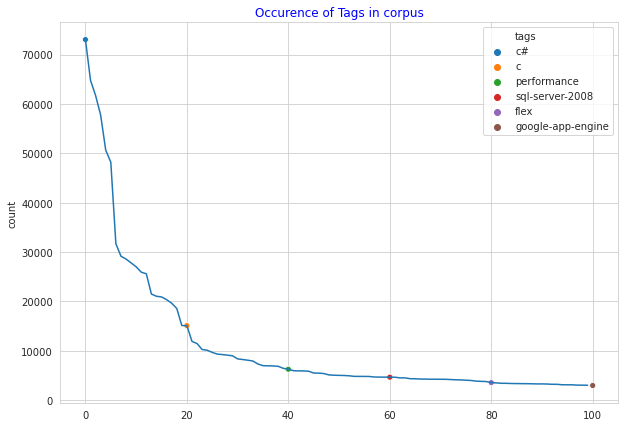

In [46]:
# lets plot the Top 100 Tags in the Corpus
plt.figure(figsize=(10,7))
sbn.set_style("whitegrid")
sbn.lineplot(data=freq_tags.iloc[:100],x=freq_tags.index[:100],y="count")
a=[0,20,40,60,80,100]
sbn.scatterplot(a,freq_tags.iloc[a,1],hue=freq_tags.iloc[a,0])
plt.title("Occurence of Tags in corpus",color="blue")

### Word Cloud for Frequent Tags in the Dataset

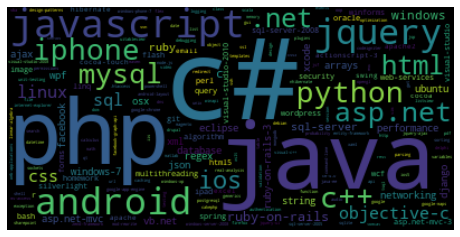

In [49]:
# creating the Dictonary with the frequent words in the dataset
t=freq_tags.tags.to_list()
c=freq_tags["count"].to_list()
tags_dic={}
for i,j in zip(t,c):
    tags_dic[i]=j

# Create and generate a word cloud image:
wordcloud = WordCloud().generate_from_frequencies(tags_dic)
plt.figure(figsize=(8,8))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

By this Word cloud --> we get c#, Java, Php, Javascript , android ,c++ occuring very frequently in the corpus.

## part-1 Defining Meta Feature before Preprocessing(Experimental)
- Number of Characters in Title 
- Number of Character in Body column
- Number of Code Segemts in each row
- Number of Words in Title

In [57]:
%%time
char_title_pre=train_data.Title.apply(lambda x:len(x))
char_body_pre=train_data.Body.apply(lambda x:len(x))
code_body_pre=train_data.Body.apply(lambda x:len(re.findall(r"<code>",x)))
words_title_pre=train_data.Title.apply(lambda x:len(str(x).split()))

CPU times: user 6.13 s, sys: 27.4 ms, total: 6.16 s
Wall time: 6.16 s


In [62]:
# Defining Some Extra StopWords seems to be Not useful
extra=['could',"would","iis","sometimes","sometime","puts","put","get","gets","help","please","need",\
       "like","know","thank","thanks","madam","sir","hii","doubt","doubts","www","com"]
li=stopwords.words("english")
li=li+extra

### Preprocessing
- Removing html tags,urls
- Removing the code segemts (assumes codes are varies much)
- Removing the Punctuations and Numbers and Keeping only text


In [63]:
def Preprocesser(doc):
    body=[]
    for text in doc:
        text=re.sub(r"href.*","",text)          #removing the href ie. removing the hyper links
        text=re.sub('<code>(.*?)</code>', '', text, flags=re.MULTILINE|re.DOTALL) # removing the code segments
        text=re.sub('<.*?>', ' ', str(text.encode('utf-8')))           #removing the Html Tags in the Text
        text=re.sub(r"[^a-zA-Z]+"," ",text)  ## removing numbers and most of Puncutuations in the Text.
        text=text.lower()                    ## converting from upper case to lower case
        body.append(" ".join([k for k in text.split() if((len(k)>2 or k=="c") and k not in li )]))
        
    return body    

In [64]:
%%time
pre_body=Preprocesser(train_data.Body)      ## Preprocessing the Body Columns
pre_text=Preprocesser(train_data.Title)     ## Preprocessing the Title Columns

CPU times: user 5min 53s, sys: 596 ms, total: 5min 53s
Wall time: 5min 53s


In [65]:
## Replacing the a Title and Body with the Preprocessed Title and Body respectively.
train_data["Title"]=pre_text
train_data["Body"]=pre_body
pre_data=train_data    # Creating a Reference for the train_data_100k 

### part 2: Defining Meta Features After Preprocessing the Dataset
- Number of words in the Title
- Number of Words in the Body


In [101]:
words_title_post=train_data.Title.apply(lambda x:len(str(x).split()))
words_body_post=train_data.Body.apply(lambda x:len(str(x).split()))

### Adding to the Dataset
- Adding the meta Feautures to the train dataset and normalize the Features.

In [113]:
train_data["char_title_pre"]=(char_title_pre-min(char_title_pre))/(max(char_title_pre)-min(char_title_pre))
train_data["char_body_pre"]=(char_body_pre-min(char_body_pre))/(max(char_body_pre)-min(char_body_pre))
train_data["code_body_pre"]=(code_body_pre-min(code_body_pre))/(max(code_body_pre)-min(code_body_pre))
train_data["words_title_pre"]=(words_title_pre-min(words_title_pre))/(max(words_title_pre)-min(words_title_pre))
train_data["words_title_post"]=(words_title_post-min(words_title_post))/(max(words_title_post)-min(words_title_post))
train_data["words_body_post"]=(words_body_post-min(words_body_post))/(max(words_body_post)-min(words_body_post))

In [114]:
train_data.head()

,Title,Body,Tags,Count_tags,char_title_pre,char_body_pre,code_body_pre,words_title_pre,words_title_post,words_body_post
0,check uploaded file image without mime type,check uploaded file image file png jpg jpeg gi...,php image-processing file-upload upload mime-t...,5,0.267677,0.009741,0.000000,0.324324,0.134615,0.013399
1,prevent firefox closing press ctrl,favorite editor vim regularly use ctrl execute...,firefox,1,0.242424,0.008543,0.000000,0.270270,0.096154,0.011111
2,error invalid type list variable,import matlab file construct data frame matlab...,r matlab machine-learning,3,0.151515,0.337555,0.012346,0.162162,0.096154,0.011765
3,replace special characters url,probably simple simply cannot find answer basi...,c# url encoding,3,0.176768,0.013588,0.000000,0.216216,0.076923,0.010458
4,modify whois contact details,using modify function displays warning mesage ...,php api file-get-contents,3,0.131313,0.024279,0.006173,0.135135,0.076923,0.002941


In [115]:
## seperate the tag columns and the droping the Tags column from the dataset
y_tagss=train_data.Tags
train_data.drop(columns="Tags",axis=1,inplace=True)

In [118]:
## reference to the pre_data
pre_data=train_data 

### Converting the Tags to Feasiable for doing Multilabels for calsffication

In [119]:
%%time
# Converting the Tags columns in to the Mulit label Classification
# initializing the Count vectorizer
tag_vect=CountVectorizer(binary=True,tokenizer=lambda x:str(x).split(),max_features=500)
vec_tag=tag_vect.fit_transform(y_tagss)

CPU times: user 7.89 s, sys: 147 ms, total: 8.04 s
Wall time: 8.04 s


In [121]:
## split the Training dataset and validataion dataset
x_train,x_val,y_train,y_val=train_test_split(pre_data.iloc[:500000,],vec_tag[:500000],test_size=0.2)
print("The shape of the Training Dataset :",x_train.shape,y_train.shape)
print("The shape of the validation Dataset :",x_val.shape,y_val.shape)

The shape of the Training Dataset : (400000, 9) (400000, 500)
The shape of the validation Dataset : (100000, 9) (100000, 500)


## Building the Models 

#### Concatenating Title And Body to a Single Feature

In [122]:
tit_bod_train=[i+" "+j for i,j in zip(x_train.Title,x_train.Body)] ## combining the both the title and Body
tit_bod_val=[i+" "+j for i,j in zip(x_val.Title,x_val.Body)]  # combining the title and Body for the Validation

In [123]:
%%time
feat_vec=TfidfVectorizer(tokenizer=lambda x:x.split(),max_features=100000,ngram_range=(1,1))
feat_vec.fit(tit_bod_train)
train_feat=feat_vec.transform(tit_bod_train)
val_feat=feat_vec.transform(tit_bod_val)

CPU times: user 50.2 s, sys: 1.01 s, total: 51.2 s
Wall time: 51.2 s


In [135]:
# Concatenate the Title_Body and Derived Features 
train_feat=hstack((train_feat,x_train.iloc[:,2:].values))
val_feat=hstack((val_feat,x_val.iloc[:,2:].values))

In [136]:
print("The Shape of the Training Dataset :",train_feat.shape)
print("The Shape of the Validation Dataset :",val_feat.shape)

The Shape of the Training Dataset : (400000, 100007)
The Shape of the Validation Dataset : (100000, 100007)


In [139]:
%%time
### Using the Log Loss (Linear MOdels --> Logistic regression)

classifier = OneVsRestClassifier(SGDClassifier(penalty='l2',loss="log",alpha=0.000001), n_jobs=-1)
classifier.fit(train_feat, y_train)
val_pre = classifier.predict(val_feat)

print("accuracy :",metrics.accuracy_score(y_val,val_pre))
print("macro f1 score :",metrics.f1_score(y_val, val_pre, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_val, val_pre, average = 'micro'))



accuracy : 0.23079
macro f1 score : 0.3446525016091632
micro f1 scoore : 0.46743106281454144
CPU times: user 2min 8s, sys: 2.72 s, total: 2min 11s
Wall time: 13min 14s


In [140]:
%%time
## Hinge Loss ---> Linear SVM Classifier 
classifier = OneVsRestClassifier(SGDClassifier(penalty='l2',loss="hinge",alpha=0.000001), n_jobs=-1)
classifier.fit(train_feat, y_train)
val_pre = classifier.predict(val_feat)

##VALIDATION ACCURACY
print("accuracy :",metrics.accuracy_score(y_val,val_pre))
print("macro f1 score :",metrics.f1_score(y_val, val_pre, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_val, val_pre, average = 'micro'))



accuracy : 0.23316
macro f1 score : 0.34536530429046775
micro f1 scoore : 0.4903430626194564
CPU times: user 2min 3s, sys: 1.66 s, total: 2min 5s
Wall time: 11min 40s


In [141]:
## TRAINING ACCURACY
val_pre = classifier.predict(train_feat)

print("accuracy :",metrics.accuracy_score(y_train,val_pre))
print("macro f1 score :",metrics.f1_score(y_train, val_pre, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_train, val_pre, average = 'micro'))



accuracy : 0.31153
macro f1 score : 0.4520044022941527
micro f1 scoore : 0.5869313236695025


In [144]:
%%time
## ‘modified_huber Loss’---> Problastic Models 
classifier = OneVsRestClassifier(SGDClassifier(penalty='l2',loss='modified_huber',alpha=0.0000001), n_jobs=-1)
classifier.fit(train_feat, y_train)
val_pre = classifier.predict(val_feat)

print("accuracy :",metrics.accuracy_score(y_val,val_pre))
print("macro f1 score :",metrics.f1_score(y_val, val_pre, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_val, val_pre, average = 'micro'))


accuracy : 0.17696
macro f1 score : 0.37701434244892607
micro f1 scoore : 0.42361195179662137
CPU times: user 2min 4s, sys: 1.63 s, total: 2min 6s
Wall time: 45min 25s


**Observations :**
- BY adding the Meta Features increased f1score slightly.
- Due to having the Memory limitations above Trainig was done only for 0.5million data points only.
- Considering only 500 Tags for Building the Model.
- Boosting algorithms or non linear algorithms can increase the time complexity due to having the large dataset and large diminesions.

**Didn't tried**:
- ngrams.(i sticked to single words only)
- Lemmetizations or stemming.
- Meta Features : Number of Nouns,
- Other Algorithms (like boosting, Naive bayes, Neural nets)--> i thought to be it may increase the Time complexity.

